In [5]:
import pandas as pd
import itertools
import cv2
import numpy as np
import json
import matplotlib
from matplotlib import pyplot as plt
import random

In [6]:
BODY_CLASSES = [
    "background",
    "foot",
    "hand",
    "arm",
    "leg",
    "torso",
    "head"
]

random.seed(0)
NUM_CLASSES = 7
colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(NUM_CLASSES)]

In [7]:
def transparent_overlays(image, annotation, alpha=0.5):
    img1 = image.copy()
    img2 = annotation.copy()

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    # img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    # dst = cv2.add(img1_bg, img2_fg)
    dst = cv2.addWeighted(image.copy(), 1-alpha, img2_fg, alpha, 0)
    img1[0:rows, 0:cols ] = dst
    return dst

def color_im(img, colors):
    for i in range(len(colors)):
        img[:,:,0][np.where(img[:,:,0] == i)] = colors[i][0]
        img[:,:,1][np.where(img[:,:,1] == i)] = colors[i][1]
        img[:,:,2][np.where(img[:,:,2] == i)] = colors[i][2]
    return img
def IoU(img1, img2, label1, label2):
    #print(img1, img2)
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    label1 = cv2.imread(label1)

    label2 = cv2.imread(label2)
    
    tmp_label2 = cv2.resize(label2, (int(label1.shape[1]), int(label1.shape[0])))
    
    label1[np.where(label1 == 0)] = 255 # to exclude the bg from intersection
    
    intersection = np.where(label1[:,:,0] == tmp_label2[:,:,0])[0].shape[0]
    union = np.where(label1[:,:,0] != 255 )[0].shape[0] + np.where(tmp_label2[:,:,0] != 0 )[0].shape[0] - intersection
    iou = intersection/union
    #print(iou)
    '''
    plt.figure(figsize=(10, 7))
    plt.imshow(img1)
    plt.show()
    
    plt.figure(figsize=(10, 7))
    plt.imshow(img2)
    plt.show()
    
    
    plt.figure(figsize=(10, 7))
    plt.imshow(transparent_overlays(color_im(label1, colors), color_im(tmp_label2, colors), 0.45))
    plt.show()
    '''
    return iou

In [8]:
label_dir = "/data/sara/semantic-segmentation-pytorch/all_body_part_annotations/"

def plot_hist_from_odgt(file_path):
    df_pairs = pd.read_json(file_path, lines=True)
    print(df_pairs.describe())
    #df_pairs = df_pairs[df_pairs['iou'] > 0.5]
    return df_pairs['iou'].hist(weights=np.ones_like(df_pairs['iou']) / len(df_pairs), figsize=(13,8))
    

def plot(filename):
    matplotlib.rcParams.update({'font.size': 24})
    ax = plot_hist_from_odgt(filename)
    ax.set_xlabel("IoU")
    ax.set_ylabel("Normalized frequency")
    #ax.set_title("Human Decomposition")
    
def analyze_iou_from_odgt(filename):
    df = pd.read_json(filename, lines=True)

    output = ""
    for row in df.iterrows():
        row = row[1]
        img1, img2 = row['fpath_img'][0], row['fpath_img'][1]
        label1 = label_dir + img1.split('/')[-1].replace(extention, 'png')
        label2 = label_dir + img2.split('/')[-1].replace(extention, 'png')
        iou = IoU(img1, img2, label1, label2)
        new_line = {}
        new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"], new_line['iou'] = \
                [img1, img2], [label1, label2], 'w', 'h', iou
        output += json.dumps(new_line) + "\n"

    with open(filename + '_iou.odgt', 'w') as fp:
        fp.write(output)
    
    plot(filename + '_iou.odgt')
    
def analyze_iou(filename):
    df = pd.read_csv(filename, sep=":", names=['img','cluster_id'])

    output = ""
    clusters = df['cluster_id'].unique()
    for cluster_id in clusters:
        sub_data = df[df['cluster_id']==cluster_id]
        for pair in itertools.combinations(sub_data['img'],2):
            img1, img2 = pair[0].replace('.icon',''), pair[1].replace('.icon','')
            extention = img1.split('/')[-1].split('.')[-1]
            label1 = label_dir + img1.split('/')[-1].replace(extention, 'png')
            label2 = label_dir + img2.split('/')[-1].replace(extention, 'png')
            iou = IoU(img1, img2, label1, label2)
            new_line = {}
            new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"], new_line['iou'] = \
                    [img1, img2], [label1, label2], 'w', 'h', iou
            output += json.dumps(new_line) + "\n"

    with open(filename + '_iou.odgt', 'w') as fp:
        fp.write(output)
    
    plot(filename + '_iou.odgt')


            iou
count  4.000000
mean   0.643846
std    0.133282
min    0.450438
25%    0.615372
50%    0.686299
75%    0.714774
max    0.752348


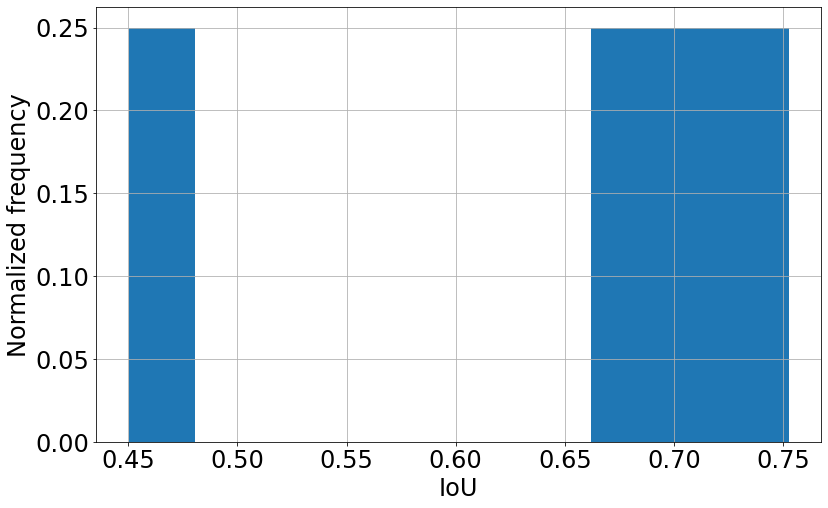

In [10]:
filename = "la"
analyze_iou(filename)

             iou
count  48.000000
mean    0.473634
std     0.221444
min     0.027549
25%     0.292106
50%     0.411575
75%     0.679515
max     0.798334


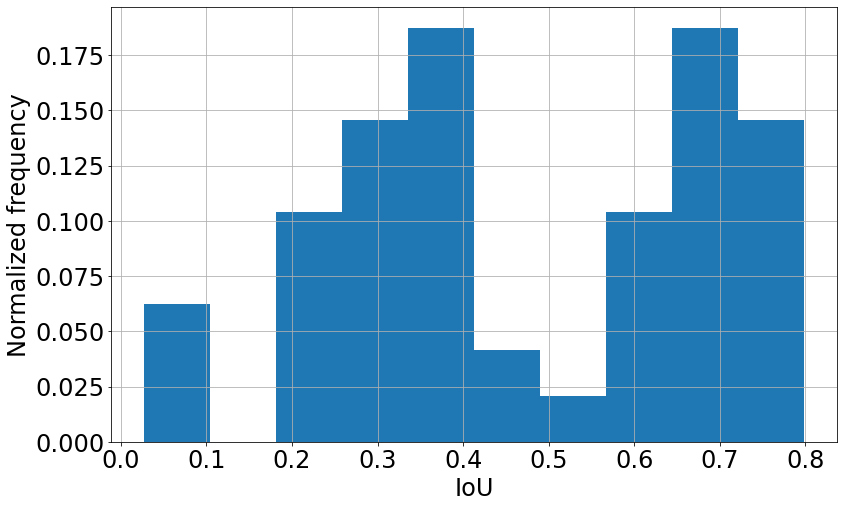

In [140]:
filename = "243sequencedpca"
analyze_iou(filename)

In [ ]:
filenames = "243sequencedpca"
analyze_iou(filename)

              iou
count  605.000000
mean     0.199832
std      0.216213
min      0.000000
25%      0.045493
50%      0.116253
75%      0.296588
max      0.932077


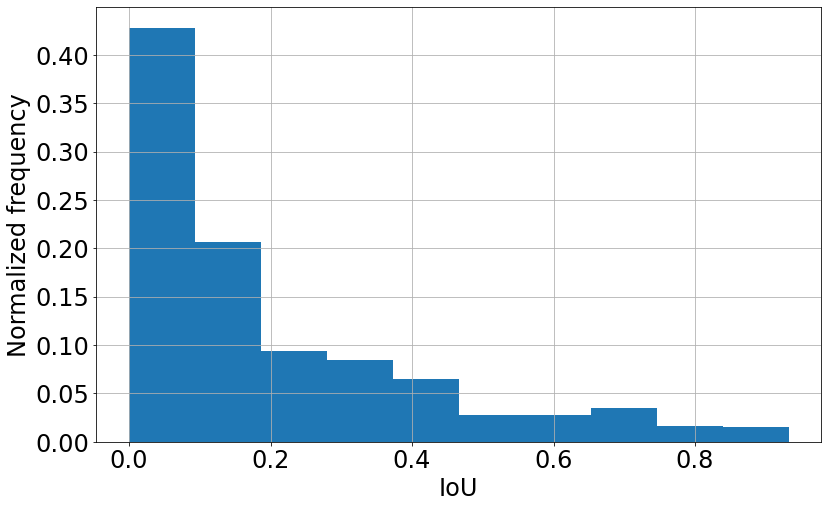

In [110]:
filename = "243_clusters"
analyze_iou(filename)

             iou
count  96.000000
mean    0.483076
std     0.266501
min     0.000000
25%     0.263074
50%     0.496734
75%     0.702375
max     0.932077


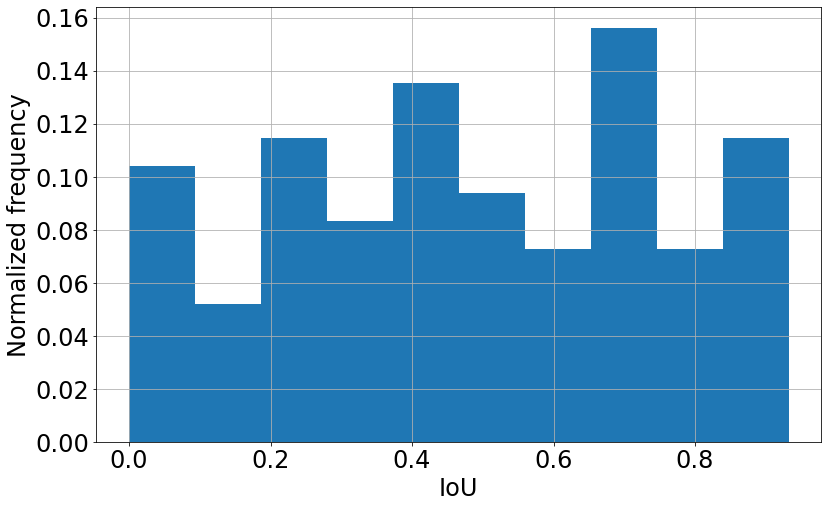

In [111]:
analyze_iou_from_odgt('243_pairs')

In [120]:
filename

'243sequencedpca'

In [121]:
df = pd.read_csv(filename, sep=":", names=['img','cluster_id'])

clusters = df['cluster_id'].unique()
for cluster_id in clusters:
    sub_data = df[df['cluster_id']==cluster_id]
    print(sub_data)
    for pair in itertools.combinations(sub_data['img'],2):
        print(pair)
    break

                                  img cluster_id
0  /usb/sara_img/24300407.08.icon.JPG      243_1
1  /usb/sara_img/24300501.06.icon.JPG      243_1
2  /usb/sara_img/24300502.04.icon.JPG      243_1
3  /usb/sara_img/24300502.20.icon.JPG      243_1
('/usb/sara_img/24300407.08.icon.JPG', '/usb/sara_img/24300501.06.icon.JPG')
('/usb/sara_img/24300407.08.icon.JPG', '/usb/sara_img/24300502.04.icon.JPG')
('/usb/sara_img/24300407.08.icon.JPG', '/usb/sara_img/24300502.20.icon.JPG')
('/usb/sara_img/24300501.06.icon.JPG', '/usb/sara_img/24300502.04.icon.JPG')
('/usb/sara_img/24300501.06.icon.JPG', '/usb/sara_img/24300502.20.icon.JPG')
('/usb/sara_img/24300502.04.icon.JPG', '/usb/sara_img/24300502.20.icon.JPG')
